## Fera Formidável 4.6
### E se meus dados forem imagens?
#### Rômulo 24024
### Enunciado:
**Objetivo:** implementar uma rede neural convolucional (CNN) utilizando PyTorch ou
lightning. Treine esta rede neural em um conjunto de dados de imagens. Explique para
o leitor como funciona a camada de convolução de uma CNN e o motivo de utilizarmos
este tipo de arquitetura quando estudamos imagens.

### Introdução:
CNN é a sigla para Rede Neural Convolucional(Convolutional Neural Network). É uma rede usada principalmente com imagens. A ideia é simples: ao invés de ligar todos os neurônios entre si (como numa MLP), ela usa filtros pequenos que percorrem a imagem e extraem padrões locais. Isso é a convolução.

Esses filtros, chamados kernels, são matrizes com valores que a rede aprende sozinha durante o treinamento. Cada filtro busca um tipo de padrão – uma borda, uma textura, etc. O filtro anda pela imagem e calcula multiplicações ponto a ponto. Isso gera um novo “mapa” com os resultados.

Dois parâmetros controlam isso:

- **Padding:** adiciona bordas artificiais na imagem, pra que o filtro consiga olhar também os cantos. Sem isso, as bordas são ignoradas.

- **Stride:** define de quantos pixels em quantos o filtro se move. Quanto maior o stride, menor a saída.

Depois da convolução, geralmente vem o pooling, que resume a informação e diminui o tamanho dos dados. Os dois tipos mais comuns são:

- **Max pooling:** pega o maior valor numa região.

- **Average pooling:** faz a média dos valores.

No final, a CNN conecta tudo numa camada totalmente conectada. Aí sim cada neurônio fala com todos os da próxima camada, como numa MLP. Essa parte final é a que toma a decisão – classifica a imagem, por exemplo.

A CNN também usa funções de ativação, como a ReLU. Ela zera os valores negativos e ajuda a rede a lidar com relações não lineares.

#### Imports necessários:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Temos que definir um transpose, para quando pegarmos os dados, dimensioná-los e transformalos em tensor.

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Agora podemos obter os dados de treino e de teste:

In [3]:
dados_treino = datasets.OxfordIIITPet(root='/cnn_data', split='trainval', download=True, transform=transform)

In [4]:
dados_teste = datasets.OxfordIIITPet(root='/cnn_data', split='test', download=True, transform=transform)

Vamos definir o loader para dividirmos os dados em lote, os dados de treino devem ser sorteados com shuffle, já os de teste não.

In [5]:
loader_treino = DataLoader(dados_treino, batch_size=32, shuffle=True)
loader_teste = DataLoader(dados_teste, batch_size=32, shuffle=False)

Vamos agora criar a classe do nosso modelo de CNN, já podemos criar todas as camadas, seja as de convolução ou totalmente conectadas e também a função de pooling padrão.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Camadas convulocionais, 3 dados de entrada que correspondem aos valores do pixel na escala RGB
        self.camada_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.camada_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.camada_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Definir o nosso pooling padrão
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Taxa de dropout
        self.dropout = nn.Dropout(0.5)

        # Definindo um Batchnorm
        self.bn1 = nn.BatchNorm2d(32)

        # As camadas totalmente conectadas
        self.camada_tc1 = nn.Linear(128 * 16 * 16, 512)
        self.camada_tc2 = nn.Linear(512, 128)
        self.camada_tc3 = nn.Linear(128, 37)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.camada_conv1(x))))
        x = self.pool(F.relu(self.camada_conv2(x)))
        x = self.pool(F.relu(self.camada_conv3(x)))
        x = torch.flatten(x, 1) # Flatten antes das camadas totalmente conectadas
        x = self.dropout(F.relu(self.camada_tc1(x)))
        x = self.dropout(F.relu(self.camada_tc2(x)))
        return self.camada_tc3(x)

Vamos criar um modelo padrão com seed para tornar os resultados reprodutíveis.

In [7]:
torch.manual_seed(77) # Tornar resultados reprodutíveis
modelo = CNN() 
modelo

CNN(
  (camada_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (camada_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (camada_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (camada_tc1): Linear(in_features=32768, out_features=512, bias=True)
  (camada_tc2): Linear(in_features=512, out_features=128, bias=True)
  (camada_tc3): Linear(in_features=128, out_features=37, bias=True)
)

Vamos definir também a nossa função de perda, como se trata de um algoritmo de classificação, será a Perda de Entropia Cruzada. E o método de otimização estocástico Adam.

In [8]:
criterio = nn.CrossEntropyLoss()
otimizador = torch.optim.Adam(modelo.parameters(), lr=0.0005)

Agora vamos treinar o nosso modelo. Vamos também analisar o tempo total levado no treinamento.

In [9]:
import time
tempo_inicial = time.time()

epocas = 17
perda_treinos = []
perda_testes = []
acertos_treino = []
acertos_teste = []

for epoca in range(epocas):
    modelo.train()
    treino_certos = 0
    soma_perda_treino = 0
    total_treino = 0

    for X_treino, y_treino in loader_treino:
        y_pred = modelo(X_treino)
        perda = criterio(y_pred, y_treino)
        predicao = torch.max(y_pred.data, 1)[1]
        treino_certos += (predicao == y_treino).sum().item()
        soma_perda_treino += perda.item() * X_treino.size(0)
        total_treino += X_treino.size(0)

        otimizador.zero_grad()
        perda.backward()
        otimizador.step()

    perda_treinos.append(soma_perda_treino / total_treino)
    acertos_treino.append(treino_certos)

    modelo.eval()
    teste_certos = 0
    soma_perda_teste = 0
    total_teste = 0
    with torch.no_grad():
        for X_teste, y_teste in loader_teste:
            y_val = modelo(X_teste)
            predicao = torch.max(y_val.data, 1)[1]
            teste_certos += (predicao == y_teste).sum().item()
            soma_perda_teste += criterio(y_val, y_teste).item() * X_teste.size(0)
            total_teste += X_teste.size(0)

    perda_testes.append(soma_perda_teste / total_teste)
    acertos_teste.append(teste_certos)

    print(f"Época: {epoca+1}/{epocas} | Perda treino: {perda_treinos[-1]:.4f} | Perda teste: {perda_testes[-1]:.4f} | Acertos treino: {treino_certos} | Acertos teste: {teste_certos}")

tempo_total = time.time() - tempo_inicial
print(f'Tempo total de treino: {tempo_total / 60} minutos')

Época: 1/17 | Perda treino: 3.6170 | Perda teste: 3.6096 | Acertos treino: 120 | Acertos teste: 148
Época: 2/17 | Perda treino: 3.5743 | Perda teste: 3.4775 | Acertos treino: 163 | Acertos teste: 237
Época: 3/17 | Perda treino: 3.4770 | Perda teste: 3.4017 | Acertos treino: 203 | Acertos teste: 303
Época: 4/17 | Perda treino: 3.4264 | Perda teste: 3.3786 | Acertos treino: 250 | Acertos teste: 336
Época: 5/17 | Perda treino: 3.3601 | Perda teste: 3.3079 | Acertos treino: 317 | Acertos teste: 386
Época: 6/17 | Perda treino: 3.3141 | Perda teste: 3.2725 | Acertos treino: 337 | Acertos teste: 392
Época: 7/17 | Perda treino: 3.2357 | Perda teste: 3.1890 | Acertos treino: 401 | Acertos teste: 441
Época: 8/17 | Perda treino: 3.1656 | Perda teste: 3.1385 | Acertos treino: 466 | Acertos teste: 499
Época: 9/17 | Perda treino: 3.0444 | Perda teste: 3.0667 | Acertos treino: 543 | Acertos teste: 534
Época: 10/17 | Perda treino: 2.9004 | Perda teste: 2.9818 | Acertos treino: 656 | Acertos teste: 618

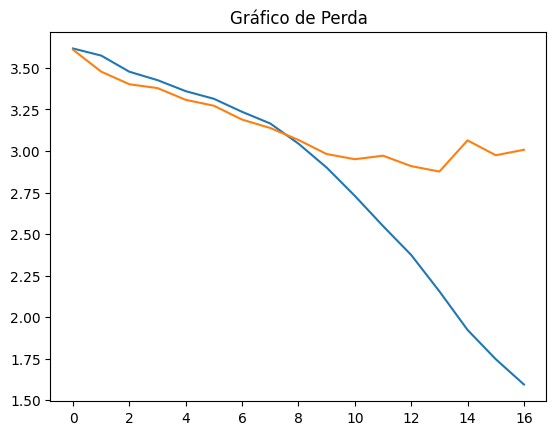

In [ ]:
plt.plot(perda_treinos, label='Perda dados de treino')
plt.plot(perda_testes, label ='Perda dados de teste')
plt.legend(['a'])
plt.title('Gráfico de Perda')
plt.show()

Text(0.5, 1.0, 'Acurácia do modelo em porcentagem')

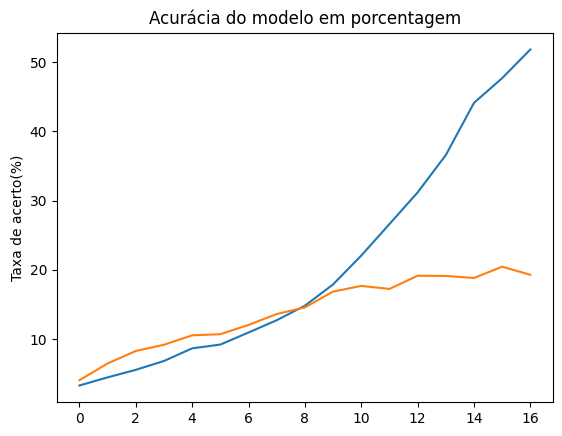

In [11]:
taxa_acerto_treino = [acerto*100/len(dados_teste) for acerto in acertos_treino]
taxa_acerto_teste = [acerto*100/len(dados_teste) for acerto in acertos_teste]

plt.plot(taxa_acerto_treino, label='Acurácia dados de treino')
plt.plot(taxa_acerto_teste, label='Acurácia dados de teste')
plt.ylabel('Taxa de acerto(%)')
plt.title('Acurácia do modelo em porcentagem')

#### Conclusão:
O modelo se mostrou relativamente eficiente para a classificação das imagens, a acurácia do teste foi muito superior a 1/37, porém ainda é uma acurácia baixa, como estamos trabalhando com 37 rótulos, e algumas raças de gatos podem ser muito parecidas, me parece um bom resultado. Tentei adicionar robustez ao modelo, mas tive custo computacional muito aumentado e pouco ganho de performance. No geral, podemos observar que o modelo para de progredir significativamente após a época 17 e a escolha do dropout foi bastante útil.

### Referências

- Deep Learning With PyTorch. Playlist de vídeos sobre CNN.

Disponível em: <http://www.youtube.com/playlist?list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1>

‌
- Classes da MLP em Python puro

 Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb